In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d preetviradiya/brian-tumor-dataset

 90% 97.0M/107M [00:00<00:00, 135MB/s]
100% 107M/107M [00:00<00:00, 139MB/s] 


In [3]:
import zipfile
zip_ref=zipfile.ZipFile('/content/brian-tumor-dataset.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [11]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten
from keras.optimizers import Adam
import pickle

In [6]:
directory = '/content/Brain Tumor Data Set/Brain Tumor Data Set'

# Create the dataset with a validation split of 20%
train_dataset = keras.utils.image_dataset_from_directory(
    directory=directory,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.2,  # 20% of the data will be used for validation
    subset='training',  # Use the training subset for this instance
    seed=42  # Set the seed to ensure that there is no overlap between the training and validation subsets
)

# Create the validation dataset using the remaining 20%
validation_dataset = keras.utils.image_dataset_from_directory(
    directory=directory,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.2,  # 20% of the data will be used for validation
    subset='validation',  # Use the validation subset for this instance
    seed=42  # Set the seed to ensure that there is no overlap between the training and validation subsets
)

Found 4514 files belonging to 2 classes.
Using 3612 files for training.
Found 4514 files belonging to 2 classes.
Using 902 files for validation.


In [7]:
#TO KEEP VALUES FROM 0 TO 1 FOR BETTER NEURAL NETWORK
def div(image,label):
  image=tf.cast(image/255.0,tf.float32)
  return image,label
train_dataset=train_dataset.map(div)
validation_dataset=validation_dataset.map(div)

# MODEL BUILDING

In [8]:
model=Sequential()
model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))
model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))
model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

# COMPILING THE MODEL

In [28]:
from keras.callbacks import Callback
from keras.metrics import Precision,Recall

class MetricsCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        recall = logs['recall']
        precision = logs['precision']
        f1_score = 2 * (precision * recall) / (precision + recall + 1e-10)
        print(f'Recall: {recall}, Precision: {precision}, F1 Score: {f1_score}')

metrics_callback = MetricsCallback()
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', Recall(), Precision()])

In [22]:
from sklearn.model_selection import KFold

In [29]:
hist=model.fit(train_dataset,epochs=10,validation_data=validation_dataset)

Epoch 1/10
113/113 [==============================] - 526s 5s/step - loss: 0.4473 - accuracy: 0.7943 - recall: 0.7118 - precision: 0.8158 - val_loss: 0.2203 - val_accuracy: 0.9169 - val_recall: 0.9097 - val_precision: 0.9161
Epoch 2/10
113/113 [==============================] - 512s 5s/step - loss: 0.2025 - accuracy: 0.9258 - recall: 0.9033 - precision: 0.9326 - val_loss: 0.1735 - val_accuracy: 0.9346 - val_recall: 0.9514 - val_precision: 0.9154
Epoch 3/10
113/113 [==============================] - 509s 4s/step - loss: 0.0860 - accuracy: 0.9729 - recall: 0.9704 - precision: 0.9704 - val_loss: 0.1157 - val_accuracy: 0.9590 - val_recall: 0.9583 - val_precision: 0.9561
Epoch 4/10
113/113 [==============================] - 510s 5s/step - loss: 0.0370 - accuracy: 0.9881 - recall: 0.9879 - precision: 0.9861 - val_loss: 0.0678 - val_accuracy: 0.9812 - val_recall: 0.9792 - val_precision: 0.9814
Epoch 5/10
113/113 [==============================] - 512s 5s/step - loss: 0.0301 - accuracy: 0.9909

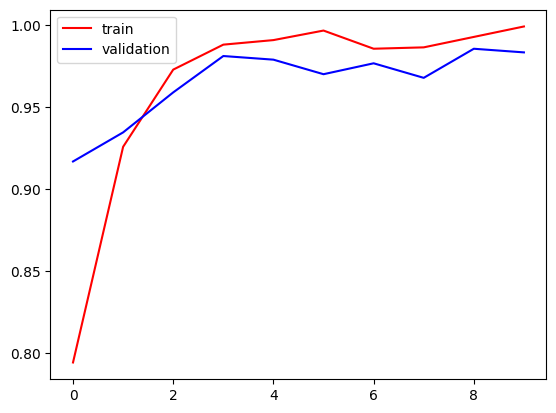

In [30]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'],color='red',label='train')
plt.plot(hist.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

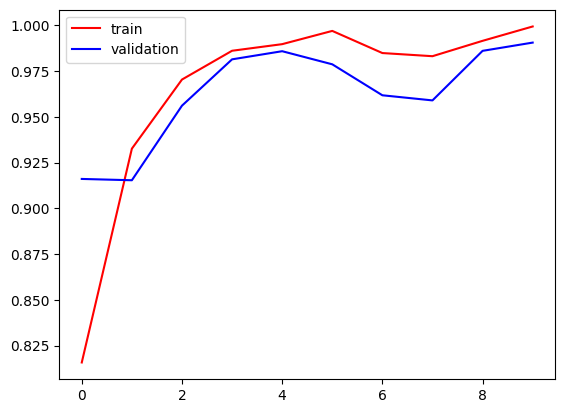

In [36]:

plt.plot(hist.history['precision'],color='red',label='train')
plt.plot(hist.history['val_precision'],color='blue',label='validation')
plt.legend()
plt.show()

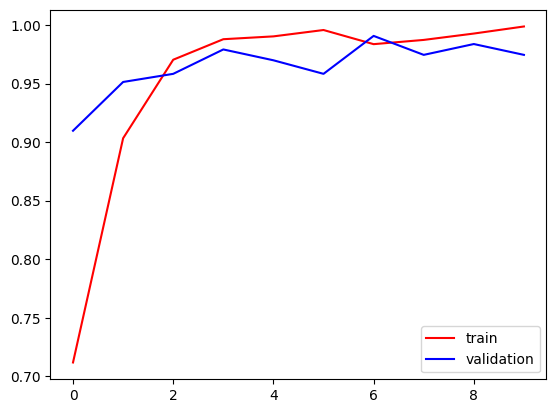

In [37]:
plt.plot(hist.history['recall'],color='red',label='train')
plt.plot(hist.history['val_recall'],color='blue',label='validation')
plt.legend()
plt.show()

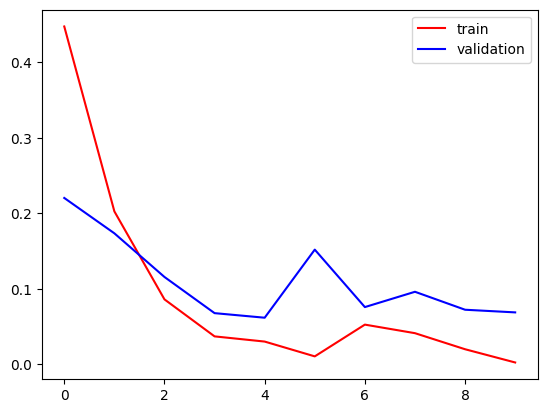

In [38]:
plt.plot(hist.history['loss'],color='red',label='train')
plt.plot(hist.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [45]:
pickle.dump(model,open('model1.pkl','wb'))

In [39]:
import cv2

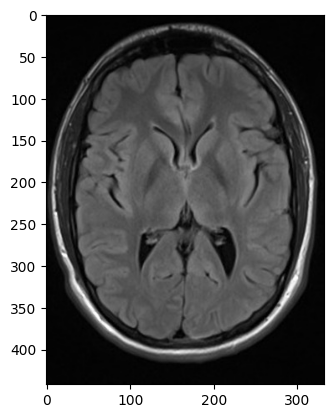

In [40]:
test=cv2.imread("/content/Brain Tumor Data Set/Brain Tumor Data Set/Healthy/Not Cancer  (1029).jpg")
plt.imshow(test)

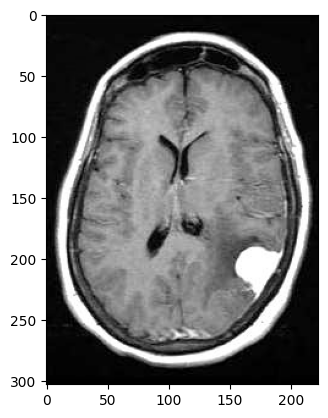

In [41]:
test1=cv2.imread("/content/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1225).jpg")
plt.imshow(test1)

In [46]:
with open('/content/model1.pkl', 'rb') as file:
    model1 = pickle.load(file)

In [47]:
test=cv2.resize(test,(256,256))
test=test.reshape((1,256,256,3))
model1.predict(test)#1 is for healthy

1/1 [==============================] - 1s 610ms/step


array([[1.]], dtype=float32)

In [49]:
test1=cv2.resize(test1,(256,256))
test1=test1.reshape((1,256,256,3))
model1.predict(test1)#0 is for tumor

1/1 [==============================] - 0s 76ms/step


array([[0.]], dtype=float32)